# Covid-19 Forecasting using an RNN

# 1. Introduction

The goal of this notebook is very simple: Generate additional features from the Covid19-global-forecasting dataset and feed it into an RNN. The RNN will take as inputs:
*     number of cases for 13 days
*     number of fatalities for 13 days
*     restrictions applied for the area in the past 13 days
*     quarantine applied for the area in the past 13 days
*     school opened or closed for the area in the past 13 days
*     additional information related to the area (population, density, number of hospital beds, lung measurement) 

as outputs:
*    number of cases for the 14th day
*    number of fatalities for the 14th day

## Update notes

* **V5**: Submission pipeline fixed - *score: 3.67449*
* **V6**: New RNN architecture with two separate branches for each output - *score: 3.26619*
* **V8**: Add a post-processing step checking if the model's output is equal or greater the previous value - *score: 2.73282*
* **V9**: Change the MSE losses to RMSLE - *score: 1.76123*
* **V11**: Change the outputs' activation fucntions from linear to ReLU - *score: 1.60605*
* **V12**: Use a 2-week period for predictions instead of 1. Replace the SimpleRNN layers with LSTM layers - *score: 1.26466*
* **V13**: Fix bug in Cell 4 (flagged by [@jeremyoudin](https://www.kaggle.com/jeremyoudin)) which made the dataset much larger due to duplicates and also created a leakage between the training and validation sets - *score: 1.46697*
* **V15**: Start introducing new inputs from the [enriched dataset](https://www.kaggle.com/optimo/covid19-enriched-dataset-week-2) by [@optimo](https://www.kaggle.com/optimo) and fix a bug which prevented the generation of 25% of the training data - *score: 1.03853*
* **V16**: Add a new input to the model based on the coutries' total population. It is added as a separate input as it is not temporal like all previous inputs - *score: 1.02947*
* **V19**: Use additional inputs using the enriched dataset. It makes the model more complex and harder to train but might be worth it! *score: 1.05385*
* **V20**: Allow a 50% overlap between sequences when generating the dataset to double its size. It creates a minor leakage between the training and validation set so it will eventually needs to be fixed. I was curious to see how it would affect performances. Beside that, it appears that the model's training phase is not perfectly stable, with the "fatality" branch not always converging. *score: 1.08343*
* **V21**: Add new figures across the notebook and a function at the end of the notebook to visualise the predictions over the period of time defined for the Public Leaderboard. - *score: 1.02837*
* **V26**: Update the notebook to compare with the latest data, fix minor errors, new charts to visualise long term predictions, and add a conclusion at the end.
* **V27**: Now running on data from COVID19 Global Forecasting (Week 3) and all dates for predictions have been updated accordingly.

*PS: Please note that the scores may have change slightly. I assume that the evaluation process is updated as new data is coming in for the period from 19/03/2020 to 01/04/2020.*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


for dirname, _, filenames in os.walk('D:/kaggle/covid19/data/covid19-global-forecasting-week-3'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:/kaggle/covid19/data/covid19-global-forecasting-week-3\submission.csv
D:/kaggle/covid19/data/covid19-global-forecasting-week-3\test.csv
D:/kaggle/covid19/data/covid19-global-forecasting-week-3\train.csv
D:/kaggle/covid19/data/covid19-global-forecasting-week-3\enriched_covid_19_week_2.csv


In [2]:
import pathlib

In [3]:
data_p = pathlib.Path('D:/kaggle/covid19/data/covid19-global-forecasting-week-3')

# 2. Preparing the training data

In [4]:
data_p/filenames[-1]

WindowsPath('D:/kaggle/covid19/data/covid19-global-forecasting-week-3/enriched_covid_19_week_2.csv')

In [5]:
train_df = pd.read_csv(data_p/filenames[-1])
train_df

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities,age_0-4,age_5-9,age_10-14,age_15-19,...,smokers_perc,density,urbanpop,hospibed,lung,femalelung,malelung,restrictions,quarantine,schools
0,1,Afghanistan,NaN,2020-01-22,0.0,0.0,0.145717,0.139133,0.133376,0.118922,...,21.389448,60.0,25.0,0.5,37.62,36.310,39.33,0,0,0
1,2,Afghanistan,NaN,2020-01-23,0.0,0.0,0.145717,0.139133,0.133376,0.118922,...,21.389448,60.0,25.0,0.5,37.62,36.310,39.33,0,0,0
2,3,Afghanistan,NaN,2020-01-24,0.0,0.0,0.145717,0.139133,0.133376,0.118922,...,21.389448,60.0,25.0,0.5,37.62,36.310,39.33,0,0,0
3,4,Afghanistan,NaN,2020-01-25,0.0,0.0,0.145717,0.139133,0.133376,0.118922,...,21.389448,60.0,25.0,0.5,37.62,36.310,39.33,0,0,0
4,5,Afghanistan,NaN,2020-01-26,0.0,0.0,0.145717,0.139133,0.133376,0.118922,...,21.389448,60.0,25.0,0.5,37.62,36.310,39.33,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,29360,Zimbabwe,NaN,2020-03-21,3.0,0.0,0.141119,0.148740,0.129252,0.110267,...,15.800000,95.0,67.0,2.7,20.61,16.065,26.70,0,0,0
18812,29361,Zimbabwe,NaN,2020-03-22,3.0,0.0,0.141119,0.148740,0.129252,0.110267,...,15.800000,95.0,67.0,2.7,20.61,16.065,26.70,0,0,0
18813,29362,Zimbabwe,NaN,2020-03-23,3.0,1.0,0.141119,0.148740,0.129252,0.110267,...,15.800000,95.0,67.0,2.7,20.61,16.065,26.70,0,0,0
18814,29363,Zimbabwe,NaN,2020-03-24,3.0,1.0,0.141119,0.148740,0.129252,0.110267,...,15.800000,95.0,67.0,2.7,20.61,16.065,26.70,0,0,0


In [6]:
#Still using the enriched data from week 3 as there is everything required for the model's training
train_df = gpd.GeoDataFrame(train_df)
train_df["Country_Region"] = [country_name.replace("'","") for country_name in train_df["Country_Region"]]
train_df["restrictions"] = train_df["restrictions"].astype("int")
train_df["quarantine"] = train_df["quarantine"].astype("int")
train_df["schools"] = train_df["schools"].astype("int")
train_df["total_pop"] = train_df["total_pop"].astype("float")
train_df["density"] = train_df["density"].astype("float")
train_df["hospibed"] = train_df["hospibed"].astype("float")
train_df["lung"] = train_df["lung"].astype("float")
train_df["total_pop"] = train_df["total_pop"]/max(train_df["total_pop"])
train_df["density"] = train_df["density"]/max(train_df["density"])
train_df["hospibed"] = train_df["hospibed"]/max(train_df["hospibed"])
train_df["lung"] = train_df["lung"]/max(train_df["lung"])
train_df.head()

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities,age_0-4,age_5-9,age_10-14,age_15-19,...,smokers_perc,density,urbanpop,hospibed,lung,femalelung,malelung,restrictions,quarantine,schools
0,1,Afghanistan,NaN,2020-01-22,0.0,0.0,0.145717,0.139133,0.133376,0.118922,...,21.389448,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0
1,2,Afghanistan,NaN,2020-01-23,0.0,0.0,0.145717,0.139133,0.133376,0.118922,...,21.389448,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0
2,3,Afghanistan,NaN,2020-01-24,0.0,0.0,0.145717,0.139133,0.133376,0.118922,...,21.389448,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0
3,4,Afghanistan,NaN,2020-01-25,0.0,0.0,0.145717,0.139133,0.133376,0.118922,...,21.389448,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0
4,5,Afghanistan,NaN,2020-01-26,0.0,0.0,0.145717,0.139133,0.133376,0.118922,...,21.389448,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0


As I was using an enriched dataset during the Week 2 competition, I have to add the new countries to my dataframe and fill the missing data with median values.

In [7]:
week3_df = gpd.GeoDataFrame(pd.read_csv(data_p/'train.csv'))
week3_df["ConfirmedCases"] = week3_df["ConfirmedCases"].astype("float")
week3_df["Fatalities"] = week3_df["Fatalities"].astype("float")
week3_df

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
22027,32703,NaN,Zimbabwe,2020-03-29,7.0,1.0
22028,32704,NaN,Zimbabwe,2020-03-30,7.0,1.0
22029,32705,NaN,Zimbabwe,2020-03-31,8.0,1.0
22030,32706,NaN,Zimbabwe,2020-04-01,8.0,1.0


In [8]:
#The country_region got modifying in the enriched dataset by @optimo, 
# so we have to apply the same change to this Dataframe.
_li = list()
for idx, row in week3_df.iterrows():
    if row['Province_State'] == "":
        _li.append(row['Country_Region'].replace("'", "").strip(" "))
    else:
        _li.append(str(row['Country_Region'].replace("'", "").strip(" ")))
week3_df["Country_Region"] = _li

In [9]:
median_pop = np.median(train_df.total_pop)
median_hospibed = np.median(train_df.hospibed)
median_density = np.median(train_df.density)
median_lung = np.median(train_df.lung)

#need to replace that with a joint using Pandas
print("The missing countries/region are:")
for country_region in week3_df.Country_Region.unique():
    if train_df.query("Country_Region=='"+country_region+"'").empty:
        print(country_region)
        add_df = week3_df.query("Country_Region=='"+country_region+"'")
        add_df["total_pop"] = median_pop
        add_df["hospibed"] = median_hospibed
        add_df["density"] = median_density
        add_df["lung"] = median_lung
        add_df["restrictions"] = 0
        add_df["quarantine"] = 0
        add_df["schools"] = 0
        train_df = train_df.append(add_df, sort=True)

The missing countries/region are:
Australia
Botswana
Burma
Burundi

C:\Users\ympai\scoop\apps\anaconda3\current\envs\kg37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\ympai\scoop\apps\anaconda3\current\envs\kg37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\ympai\scoop\apps\anaconda3\current\envs\kg37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra


Canada
China
Kosovo
MS Zaandam
Sierra Leone
US
West Bank and Gaza


I create a new dataframe where I will only store 13-day trends for each location with the resulting numbers on the 14th day. The time periods extracted do not overlap on purpose.

In [10]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","quarantine_trend","school_trend","total_population","expected_cases","expected_fatalities"})

In [11]:
#Just getting rid of the first days to have a multiple of 14
#Makes it easier to generate the sequences
train_df = train_df.query("Date>'2020-01-22'and Date<='2020-03-25'")
days_in_sequence = 14

trend_list = []

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
            province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            
            #I added a quick hack to double the number of sequences
            #Warning: This will later create a minor leakage from the 
            # training set into the validation set.
            for i in range(0,len(province_df),int(days_in_sequence/2)):
                if i+days_in_sequence<=len(province_df):
                    #prepare all the temporal inputs
                    infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                    fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                    restriction_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                    quarantine_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                    school_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]

                    #preparing all the demographic inputs
                    total_population = float(province_df.iloc[i].total_pop)
                    density = float(province_df.iloc[i].density)
                    hospibed = float(province_df.iloc[i].hospibed)
                    lung = float(province_df.iloc[i].lung)

                    expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                    expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                    trend_list.append({"infection_trend":infection_trend,
                                       "fatality_trend":fatality_trend,
                                       "restriction_trend":restriction_trend,
                                       "quarantine_trend":quarantine_trend,
                                       "school_trend":school_trend,
                                       "demographic_inputs":[total_population,density,hospibed,lung],
                                       "expected_cases":expected_cases,
                                       "expected_fatalities":expected_fatalities})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)

Preparing the inputs and shuffling the dataframe to make sure we have a bit of everything in our training and validation set.

In [12]:
trend_df["temporal_inputs"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"],trends["restriction_trend"],trends["quarantine_trend"],trends["school_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

In [13]:
trend_df.head()

,infection_trend,fatality_trend,restriction_trend,quarantine_trend,school_trend,demographic_inputs,expected_cases,expected_fatalities,temporal_inputs
1197,"[91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 102...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.025933259892085968, 0.003607092683297262, 0...",127.0,2.0,"[[91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 10..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.017716570420520272, 0.003607092683297262, 0...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1256,"[2.0, 2.0, 5.0, 8.0, 8.0, 8.0, 10.0, 10.0, 12....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.025933259892085968, 0.003607092683297262, 0...",21.0,1.0,"[[2.0, 2.0, 5.0, 8.0, 8.0, 8.0, 10.0, 10.0, 12..."
1060,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.025933259892085968, 0.003607092683297262, 0...",2.0,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
626,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Only keeping 25 sequences where the number of cases stays at 0, as there were way too many of these samples in our dataset.

In [14]:
i=0
temp_df = pd.DataFrame()
for idx,row in trend_df.iterrows():
    if sum(row.infection_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<25:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [15]:
trend_df.head()

,demographic_inputs,expected_cases,expected_fatalities,fatality_trend,infection_trend,quarantine_trend,restriction_trend,school_trend,temporal_inputs
1197,"[0.025933259892085968, 0.003607092683297262, 0...",127.0,2.0,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 102...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 10..."
2,"[0.017716570420520272, 0.003607092683297262, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1256,"[0.025933259892085968, 0.003607092683297262, 0...",21.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 5.0, 8.0, 8.0, 8.0, 10.0, 10.0, 12....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[2.0, 2.0, 5.0, 8.0, 8.0, 8.0, 10.0, 10.0, 12..."
1060,"[0.025933259892085968, 0.003607092683297262, 0...",2.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
626,"[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Splitting my dataset with 90% for training and 10% for validation

In [16]:
sequence_length = 13
training_percentage = 0.9

In [17]:
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [18]:
X_temporal_train = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,5,sequence_length))).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in training_df["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [19]:
X_temporal_test = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,5,sequence_length))).astype(np.float32)
X_demographic_test = np.asarray([np.asarray(x) for x in validation_df["demographic_inputs"]]).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

# 3. Build the model

The model is very simple in terms of architecture. The only difference from what could traditionally be seen is that it has two outputs so we can have two different losses (one for the expected number of cases and for the expected number of fatalities).

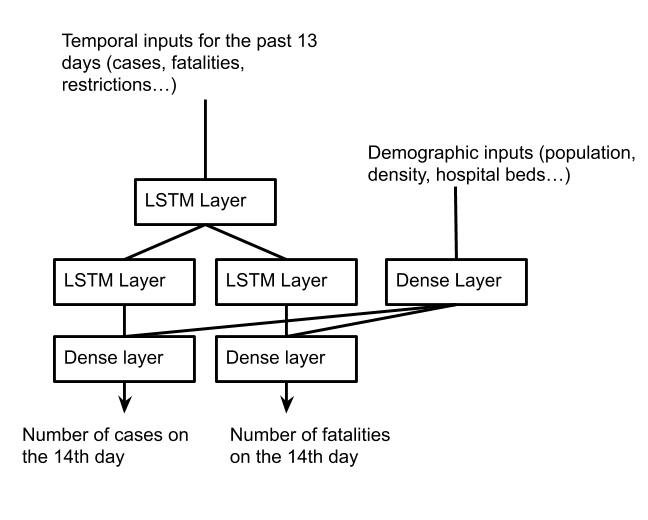

In [21]:
#temporal input branch
temporal_input_layer = Input(shape=(5,sequence_length))
main_rnn_layer = layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
demographic_input_layer = Input(shape=(4))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#cases output branch
rnn_c = layers.LSTM(64)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(256)(merge_c)
dropout_c = layers.Dropout(0.3)(dense_c)
cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c)

#fatality output branch
rnn_f = layers.LSTM(64)(main_rnn_layer)
merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(256)(merge_f)
dropout_f = layers.Dropout(0.3)(dense_f)
fatalities = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="fatalities")(dropout_f)


model = Model([temporal_input_layer,demographic_input_layer], [cases,fatalities])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 5, 128)       72704       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           80          input_2[0][0]                    
______________________________________________________________________________________________

In [39]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [40]:
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 1000, 
          batch_size = 16, 
          validation_data=([X_temporal_test,X_demographic_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Train on 940 samples, validate on 105 samples
Epoch 1/1000
940/940 [==============================] - 7s 8ms/sample - loss: 8.5748 - cases_loss: 7.2882 - fatalities_loss: 1.2942 - val_loss: 2.8558 - val_cases_loss: 2.8534 - val_fatalities_loss: 0.0826
Epoch 2/1000
940/940 [==============================] - 1s 1ms/sample - loss: 3.1441 - cases_loss: 2.4934 - fatalities_loss: 0.6492 - val_loss: 1.6079 - val_cases_loss: 1.5797 - val_fatalities_loss: 0.0951
Epoch 3/1000
940/940 [==============================] - 1s 1ms/sample - loss: 2.3309 - cases_loss: 1.7969 - fatalities_loss: 0.5514 - val_loss: 1.2087 - val_cases_loss: 1.1413 - val_fatalities_loss: 0.1054
Epoch 4/1000
940/940 [==============================] - 1s 1ms/sample - loss: 1.9764 - cases_loss: 1.4881 - fatalities_loss: 0.5033 - val_loss: 0.9447 - val_cases_loss: 0.8754 - val_fatalities_loss: 0.1073
Epoch 5/1000
940/940 [==============================] - 1s 1ms/sample - loss: 1.7518 - cases_loss: 1.2759 - fatalities_loss: 0.471

# 4. Performance during training

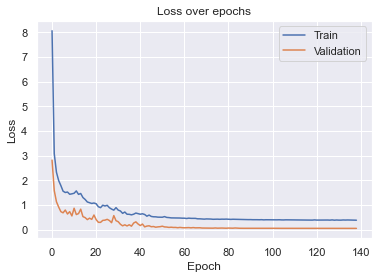

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

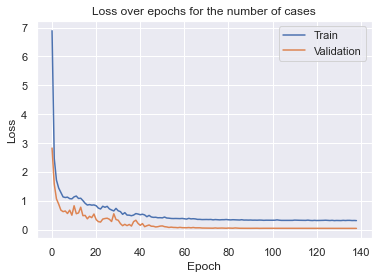

In [25]:
plt.plot(history.history['cases_loss'])
plt.plot(history.history['val_cases_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

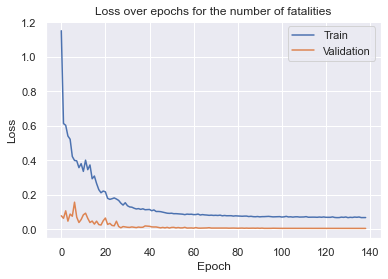

In [26]:
plt.plot(history.history['fatalities_loss'])
plt.plot(history.history['val_fatalities_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# 5. Generate predictions using the model

We can quickly check the quality of the predictions... One thing is clear, there is room for improvement!

In [21]:
del model

In [35]:
import gc
gc.collect()

10906

In [22]:
model.load_weights("best_model.h5")

In [23]:
predictions = model.predict([X_temporal_test,X_demographic_test])

I only display what I call "temporal" inputs as we're simply trying to have a feeling of how well our model is fitting the trends.

In [24]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

[[10. 10. 11. 11. 15. 18. 21. 21. 36. 49. 57. 71. 94.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Expected cases: 121.0  Prediction: 114.53458 Expected fatalities: 0.0  Prediction: -0.05841124
[[157. 159. 162. 162. 163. 163. 168. 168. 168. 168. 168. 168. 168.]
 [  4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   5.   5.   5.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
Expected cases: 168.0  Prediction: 210.59447 Expected fatalities: 5.0  Prediction: 4.7020497
[[245. 245. 245. 245. 245. 245. 245. 245. 245. 245. 245. 245. 245.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   

# 6. Apply the model to predict future trends

The following functions will be used to get the 13 previous days from a given date and demographic information, predict the number of cases and fatalities, before iterating again. Therefore, it will use the prediction for the next day as part of the data for the one afterwards.

In [25]:
#Will retrieve the number of cases and fatalities for the past 6 days from the given date
def build_inputs_for_date(country, province, date, df):
    start_date = date - timedelta(days=13)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    df = df.query("Country_Region=='"+str(country)+"' and Province_State=='"+str(province)+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    
    #preparing the temporal inputs
    temporal_input_data = np.reshape(np.asarray([df["ConfirmedCases"],
                                                 df["Fatalities"],
                                                 df["restrictions"],
                                                 df["quarantine"],
                                                 df["schools"]]),
                                     (5,sequence_length)).astype(np.float32)
    
    #preparing all the demographic inputs
    total_population = float(province_df.iloc[i].total_pop)
    density = float(province_df.iloc[i].density)
    hospibed = float(province_df.iloc[i].hospibed)
    lung = float(province_df.iloc[i].lung)
    demographic_input_data = [total_population,density,hospibed,lung]
    
    return [np.array([temporal_input_data]), np.array([demographic_input_data])]

In [26]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(country, province, df):
    begin_prediction = "2020-03-26"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-05-07"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(country, province, date, df)
        result = model.predict(input_data)
        
        #just ensuring that the outputs is
        #higher than the previous counts
        
        result[0] = np.round(result[0])
        if result[0]<input_data[0][0][0][-1]:
            result[0]=np.array([[input_data[0][0][0][-1]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[0][0][1][-1]:
            result[1]=np.array([[input_data[0][0][1][-1]]])
        
        #We assign the quarantine and school status
        #depending on previous values
        #e.g Once a country is locked, it will stay locked until the end
        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        "restrictions": 1 if any(input_data[0][0][2]) else 0,
                        "quarantine": 1 if any(input_data[0][0][3]) else 0,
                        "schools": 1 if any(input_data[0][0][4]) else 0,
                        "total_pop": input_data[1][0],
                        "density": input_data[1][0][1],
                        "hospibed": input_data[1][0][2],
                        "lung": input_data[1][0][3],
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=True)
    return df

In [27]:
#The functions that are called here need to optimise, sorry about that!
copy_df = train_df
with tqdm(total=len(list(copy_df.Country_Region.unique()))) as pbar:
    for country in copy_df.Country_Region.unique():
        for province in copy_df.query("Country_Region=='"+country+"'").Province_State.unique():
            copy_df = predict_for_region(country, province, copy_df)
        pbar.update(1)

ValueError: cannot reshape array of size 0 into shape (5,13)

# 7. Check the model's performance for the end of March 2020

In [26]:
groundtruth_df = gpd.read_file("/kaggle/input/covid19-global-forecasting-week-3/train.csv")

groundtruth_df["ConfirmedCases"] = groundtruth_df["ConfirmedCases"].astype("float")
groundtruth_df["Fatalities"] = groundtruth_df["Fatalities"].astype("float")
#The country_region got modifying in the enriched dataset by @optimo, 
# so we have to apply the same change to this Dataframe.
groundtruth_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in groundtruth_df.iterrows()]

last_date = groundtruth_df.Date.unique()[-1]

In [27]:
#to remove annoying warnings from pandas
pd.options.mode.chained_assignment = None

def get_RMSLE_per_region(region, groundtruth_df, display_only=False):
    groundtruth_df["ConfirmedCases"] = groundtruth_df["ConfirmedCases"].astype("float")
    groundtruth_df["Fatalities"] = groundtruth_df["Fatalities"].astype("float")
    
    #we only take data until the 30th of March 2020 as the groundtruth was not available for later dates.
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-03-26' and Date<='"+last_date+"'")
    predictions = copy_df.query("Country_Region=='"+region+"' and Date>='2020-03-26' and Date<='"+last_date+"'")
    
    RMSLE_cases = np.sqrt(mean_squared_log_error( groundtruth.ConfirmedCases.values, predictions.ConfirmedCases.values ))
    RMSLE_fatalities = np.sqrt(mean_squared_log_error( groundtruth.Fatalities.values, predictions.Fatalities.values ))
    
    if display_only:
        print(region)
        print("RMSLE on cases:",np.mean(RMSLE_cases))
        print("RMSLE on fatalities:",np.mean(RMSLE_fatalities))
    else:
        return RMSLE_cases, RMSLE_fatalities

In [28]:
def get_RMSLE_for_all_regions(groundtruth_df):
    RMSLE_cases_list = []
    RMSLE_fatalities_list = []
    for region in groundtruth_df.Country_Region.unique():
        RMSLE_cases, RMSLE_fatalities = get_RMSLE_per_region(region, groundtruth_df, False)
        RMSLE_cases_list.append(RMSLE_cases)
        RMSLE_fatalities_list.append(RMSLE_fatalities)
    print("RMSLE on cases:",np.mean(RMSLE_cases_list))
    print("RMSLE on fatalities:",np.mean(RMSLE_fatalities_list))

We can first check whether one of the outputs is globally harder to predict than the other.

In [29]:
get_RMSLE_for_all_regions(groundtruth_df)

RMSLE on cases: 0.5571167344528047
RMSLE on fatalities: 0.3887527208909664


Now, let's check how we are performing on two groups:
* Countries known to have an outbreak
* Countries with relatively "few" cases

In [30]:
badly_affected_countries = ["France","Italy","United Kingdom","Spain","Iran","Germany"]
for country in badly_affected_countries:
    get_RMSLE_per_region(country, groundtruth_df, display_only=True)

France
RMSLE on cases: 0.6307690610136615
RMSLE on fatalities: 0.960023558478135
Italy
RMSLE on cases: 0.32472206489509575
RMSLE on fatalities: 0.45373064028007276
United Kingdom
RMSLE on cases: 0.9143437511698559
RMSLE on fatalities: 0.7221875378766484
Spain
RMSLE on cases: 0.6006823998877464
RMSLE on fatalities: 0.7667965629006568
Iran
RMSLE on cases: 0.45212079715575226
RMSLE on fatalities: 0.3057703550909408
Germany
RMSLE on cases: 0.6102397039225008
RMSLE on fatalities: 0.21327112353513994


In [31]:
healthy_countries = ["Taiwan*","Singapore","Kenya","Slovenia","Portugal", "Israel"]
for country in healthy_countries:
    get_RMSLE_per_region(country, groundtruth_df, display_only=True)

Taiwan*
RMSLE on cases: 0.08439829283367851
RMSLE on fatalities: 0.5166414047147863
Singapore
RMSLE on cases: 0.09120304543228681
RMSLE on fatalities: 0.6525062192636425
Kenya
RMSLE on cases: 0.4646832230563873
RMSLE on fatalities: 0.9354305928929468
Slovenia
RMSLE on cases: 0.17302791757374386
RMSLE on fatalities: 0.11195049955783236
Portugal
RMSLE on cases: 0.5941531028501336
RMSLE on fatalities: 0.6199231859758285
Israel
RMSLE on cases: 0.3191610109954661
RMSLE on fatalities: 1.0150467075042109


# 8. Outputs: Observing the curves

I am using the original training CSV file instead of the enriched dataset as it is up-to-date with the latest stats from this week.

In [32]:
def display_comparison(region,groundtruth_df):
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-03-26' and Date<='2020-04-08'")
    prediction = copy_df.query("Country_Region=='"+region+"' and Date>='2020-03-26' and Date<='2020-04-08'")
    
    plt.plot(groundtruth.ConfirmedCases.values)
    plt.plot(prediction.ConfirmedCases.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.Fatalities.values)
    plt.plot(prediction.Fatalities.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

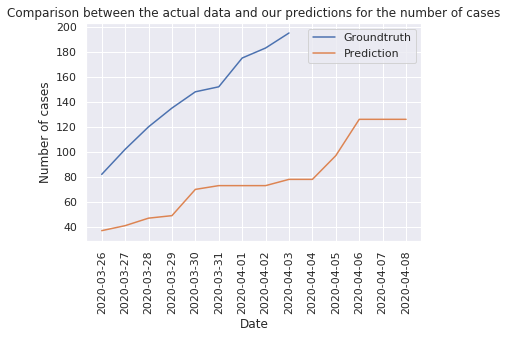

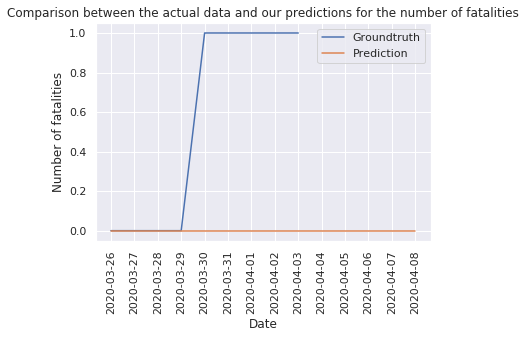

In [33]:
display_comparison("Canada_Newfoundland and Labrador", groundtruth_df)

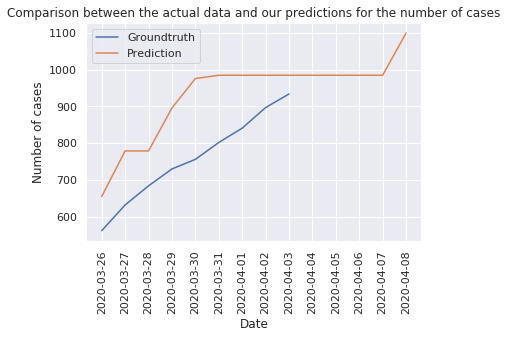

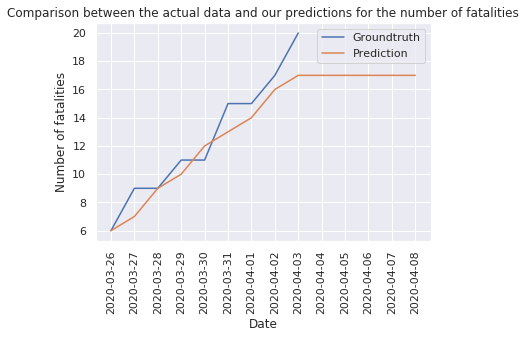

In [34]:
display_comparison("Slovenia", groundtruth_df)

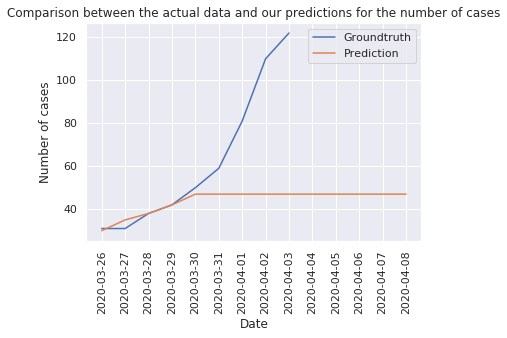

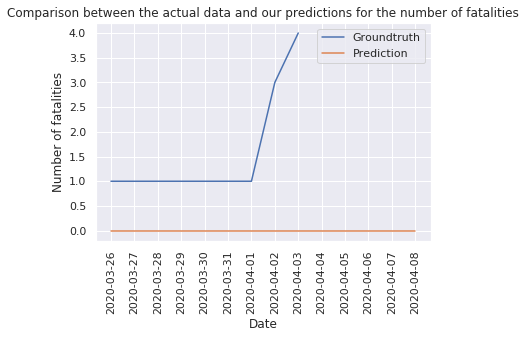

In [35]:
display_comparison("Kenya", groundtruth_df)

Now let's see how well the model perform on a much longer period.

In [36]:
def display_long_term_prediction(region,groundtruth_df):
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-03-26' and Date<='2020-04-08'")
    prediction = copy_df.query("Country_Region=='"+region+"' and Date>='2020-03-26' and Date<='2020-05-07'")
    
    plt.plot(groundtruth.ConfirmedCases.values)
    plt.plot(prediction.ConfirmedCases.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.Fatalities.values)
    plt.plot(prediction.Fatalities.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

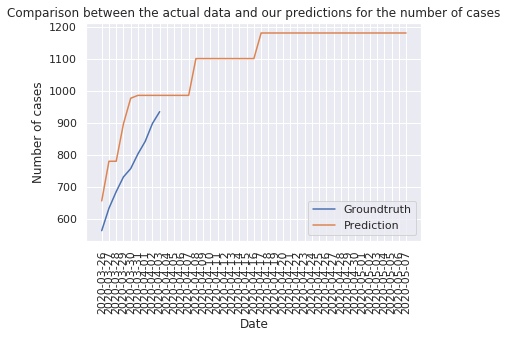

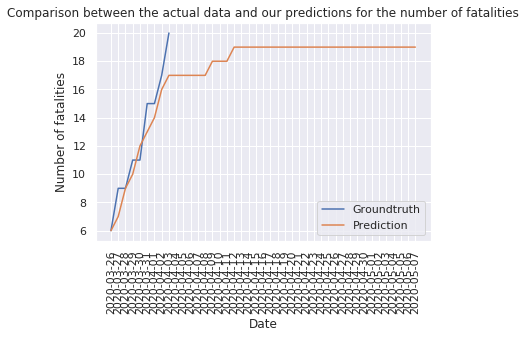

In [37]:
display_long_term_prediction("Slovenia", groundtruth_df)

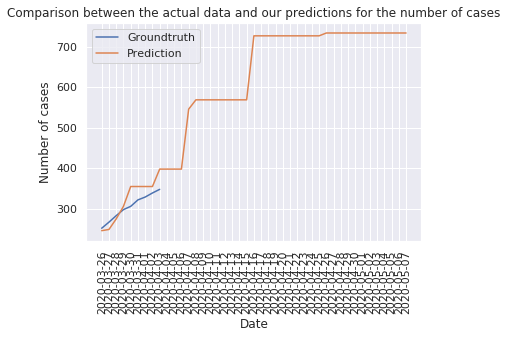

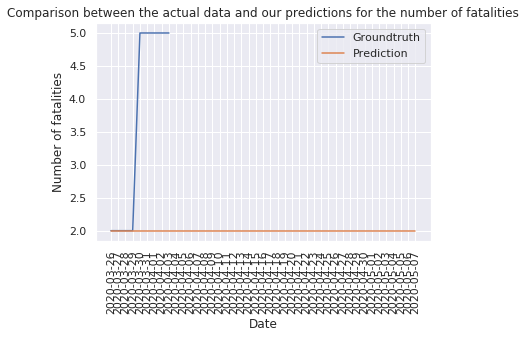

In [38]:
display_long_term_prediction("Taiwan*", groundtruth_df)

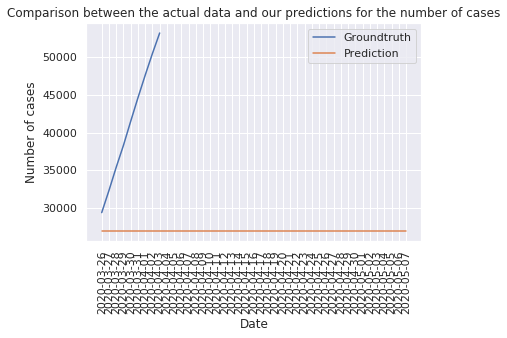

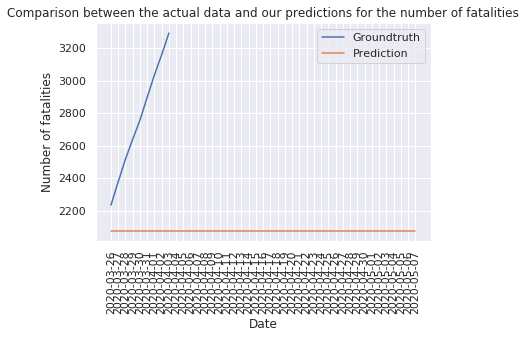

In [39]:
display_long_term_prediction("Iran", groundtruth_df)

# 9. Generating the submission file

In [40]:
test_df = gpd.read_file("/kaggle/input/covid19-global-forecasting-week-3/test.csv")
#The country_region got modifying in the enriched dataset by @optimo, 
# so we have to apply the same change to the test Dataframe.
test_df["Country_Region"] = [ row.Country_Region if row.Province_State=="" else row.Country_Region+"_"+row.Province_State for idx,row in test_df.iterrows() ]
test_df.head()

,ForecastId,Province_State,Country_Region,Date,geometry
0,1,,Afghanistan,2020-03-26,None
1,2,,Afghanistan,2020-03-27,None
2,3,,Afghanistan,2020-03-28,None
3,4,,Afghanistan,2020-03-29,None
4,5,,Afghanistan,2020-03-30,None


Just need to do this little trick to extract the relevant date and the forecastId and add that to the submission file.

In [41]:
submission_df = pd.DataFrame(columns=["ForecastId","ConfirmedCases","Fatalities"])
with tqdm(total=len(test_df)) as pbar:
    for idx, row in test_df.iterrows():
        #Had to remove single quotes because of countries like Cote D'Ivoire for example
        country_region = row.Country_Region.replace("'","").strip(" ")
        province_state = row.Province_State.replace("'","").strip(" ")
        item = copy_df.query("Country_Region=='"+country_region+"' and Province_State=='"+province_state+"' and Date=='"+row.Date+"'")
        submission_df = submission_df.append({"ForecastId":row.ForecastId,
                                              "ConfirmedCases":int(item.ConfirmedCases.values[0]),
                                              "Fatalities":int(item.Fatalities.values[0])},
                                             ignore_index=True)
        pbar.update(1)

100%|██████████| 13158/13158 [03:54<00:00, 56.17it/s]


In [42]:
submission_df.sample(20)

,ForecastId,ConfirmedCases,Fatalities
8508,8509,3250,39
5239,5240,1090,10
4764,4765,1051,0
4073,4074,1185,23
2531,2532,1015,11
3393,3394,994,8
4582,4583,662,0
8487,8488,3088,39
12427,12428,0,0
2559,2560,1433,8


In [43]:
submission_df.to_csv("submission.csv",index=False)

# 10. Conclusion

As there is still "little" data available for such kind of model, it was clearly an ambitious approach but I was curious to see how far we could go with such solution. It appears that the model was reasonably good at predicting the earlier stages of the spread when the numbers are still in the few hundreds, but then it seems to plateau far too early. It also appears to be performing awfully in countries when the outbreaks are already at an advanced stage. 
When looking back at the version notes, it seems that adding information about the regions improved the model's performance in a minor with significant manner. Information about the restrictions on populations over time showed more impact than demographic information such as the number of hospital beds or density of population.
While many other models have demonstrated far better results, I think this "naive" model could be interesting on the long run as more data become available, mostly due to how easy it is to integrate more new inputs to the model.

### If you found this notebook helpful, please give it an upvote. It will be greatly appreciated!